In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

This notebook selects the dimension and preprocess all the data into trainable values. 

## 1. Loading dataset

In [2]:
dataset_df = pd.read_csv('data/filtered_nrel.csv', delimiter='\t')
print('Dataset shape: ', dataset_df.shape)

Dataset shape:  (4053, 74)


The dataset contains 67622 rows and 28 columns. The top 5 rows are shown below.

## 2. Exploratory Data Analysis

First, we delete the columns that are not useful for our analysis. 

In [3]:
core_params = [
    'Cards Accepted', 'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count',
    'EV Network', 'Latitude', 'Longitude', 'Owner Type Code',
    'EV Connector Types', 'Restricted Access', 'Facility Type',
    'EV Pricing', 'EV On-Site Renewable Source', 
    'Maximum Vehicle Class', 'EV Workplace Charging'
]
dataset_df = dataset_df[core_params]

Then, we check the basic distribution of the data.

In [4]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4053 entries, 0 to 4052
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cards Accepted               476 non-null    object 
 1   EV Level1 EVSE Num           8 non-null      float64
 2   EV Level2 EVSE Num           1782 non-null   float64
 3   EV DC Fast Count             2535 non-null   float64
 4   EV Network                   4053 non-null   object 
 5   Latitude                     4053 non-null   float64
 6   Longitude                    4053 non-null   float64
 7   Owner Type Code              1935 non-null   object 
 8   EV Connector Types           4053 non-null   object 
 9   Restricted Access            741 non-null    object 
 10  Facility Type                1396 non-null   object 
 11  EV Pricing                   799 non-null    object 
 12  EV On-Site Renewable Source  11 non-null     object 
 13  Maximum Vehicle Cl

In [5]:
dataset_df.describe()

,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude
count,8.00000,1782.000000,2535.000000,4053.000000,4053.000000
mean,1.37500,2.287318,6.145168,38.004304,-93.601466
std,1.06066,1.622223,4.904960,5.220180,16.845066
min,1.00000,1.000000,1.000000,18.111876,-159.456719
25%,1.00000,2.000000,2.000000,34.447837,-106.341500
50%,1.00000,2.000000,4.000000,38.777042,-88.012535
75%,1.00000,2.000000,8.000000,41.578330,-80.366070
max,4.00000,18.000000,51.000000,61.573564,-65.821744


## 3. Feature Engineering

First, we categorize the types of features into 3 groups: numerical, categorical, and boolean.

In [6]:
num_attribs = dataset_df.select_dtypes('number').columns.to_list()
cat_attribs = dataset_df.select_dtypes('object').columns.to_list()
bool_attribs = dataset_df.select_dtypes('bool').columns.to_list()
print('Numerical attributes: ', num_attribs)
print('Categorical attributes: ', cat_attribs)
print('Boolean attributes: ', bool_attribs)

Numerical attributes:  ['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'Latitude', 'Longitude']
Categorical attributes:  ['Cards Accepted', 'EV Network', 'Owner Type Code', 'EV Connector Types', 'Restricted Access', 'Facility Type', 'EV Pricing', 'EV On-Site Renewable Source', 'Maximum Vehicle Class']
Boolean attributes:  ['EV Workplace Charging']


Convert boolean attributes into integers.

In [7]:
for bool_attrib in bool_attribs:
    dataset_df[bool_attrib] = dataset_df[bool_attrib].astype('int64')
dataset_df['Restricted Access'] = dataset_df['Restricted Access'].apply(lambda x: 1 if x == 'True' else 0)

Define functions to retrieve price information from the texts. 

In [8]:
def get_park_price(x):
    x = str(x)
    if str(x).lower() == 'free':
        return 0
    # Extract hourly rate
    hourly_rate = re.findall(r'(\$\d+\.?\d*)-(\$\d+\.?\d*)/Hr \w+ Parking Fee', x)
    if not hourly_rate:
        hourly_rate = re.findall(r'(\$\d+\.?\d*)/Hr Parking Fee', x)
    # Convert to float if hourly_rate is found else return None
    hourly_rate = re.findall(r'\d+\.?\d*', str(hourly_rate))
    for i in range(len(hourly_rate)):
        hourly_rate[i] = float(hourly_rate[i])
    if hourly_rate:
        return np.mean(hourly_rate)
    else:
        return -1
    
def get_electric_price(x):
    x = str(x)
    if x.lower() == 'free':
        return 0
    # Extract hourly rate
    rate = re.findall(r'(\$\d+\.?\d*)-(\$\d+\.?\d*)/kWh \w+ Energy Fee', x)
    if not rate:
        rate = re.findall(r'(\$\d+\.?\d*)/kWh Energy Fee', x)
    if not rate:
        rate = re.findall(r'(\$\d+\.?\d*) per kWh', x)
    # Convert to float if rate is found else return None
    rate = re.findall(r'\d+\.?\d*', str(rate))
    for i in range(len(rate)):
        rate[i] = float(rate[i])
    if rate:
        return np.mean(rate)
    else:
        return -1
                     

Apply the function to the data and get two columns for parking price and electricity price.

In [9]:
dataset_df['park_price'] = dataset_df['EV Pricing'].apply(get_park_price)
dataset_df['electric_price'] = dataset_df['EV Pricing'].apply(get_electric_price)
dataset_df.drop('EV Pricing', axis=1, inplace=True)

Then, we deal with the numerical features. The histogram of the numerical features are shown below.

<Axes: xlabel='EV DC Fast Count', ylabel='Count'>

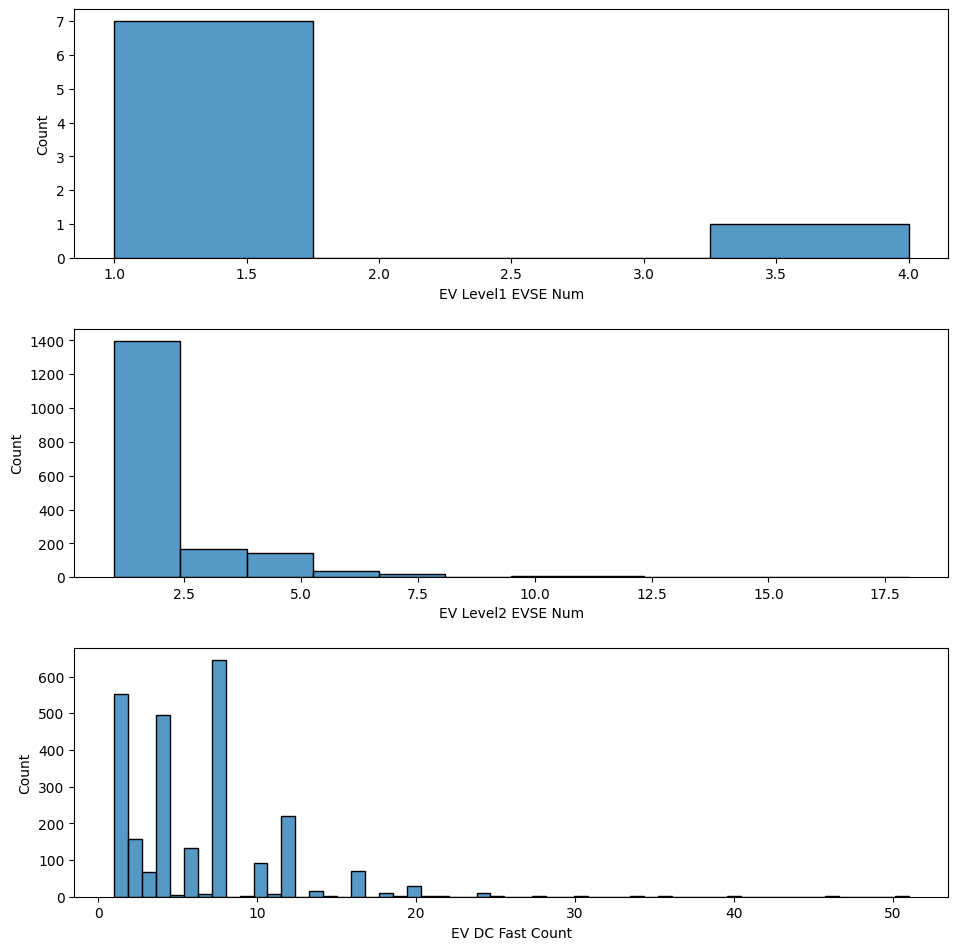

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
fig.tight_layout(pad=3.0)

sns.histplot(dataset_df['EV Level1 EVSE Num'], ax=ax[0])
sns.histplot(dataset_df['EV Level2 EVSE Num'], ax=ax[1])
sns.histplot(dataset_df['EV DC Fast Count'], ax=ax[2])

Since the data is obviously skewed right. It is reasonable to fill the missing values with zero. 

In [11]:
dataset_df['EV Level1 EVSE Num'].fillna(0, inplace=True)
dataset_df['EV Level2 EVSE Num'].fillna(0, inplace=True)
dataset_df['EV DC Fast Count'].fillna(0, inplace=True)

In [12]:
print('Sample data: ', dataset_df['Cards Accepted'].value_counts().index[0])
print('Num of unique values: ', dataset_df['Cards Accepted'].nunique())

Sample data:  A D Debit M V
Num of unique values:  15


The data in card accepted are arrays separated by empty space. We can extract the most common keys from the API and create categorical features for each of them.

In [13]:
card_list = ['A', 'CREDIT', 'Debit', 'D', 'M', 'V', 'Visa',
             'Cash', 'Checks', 'ACCOUNT_BALANCE', 'ALLIANCE',
             'ANDROID_PAY', 'APPLE_PAY']

In [14]:
for card in card_list:
    dataset_df['Card_' + card] = dataset_df['Cards Accepted'].apply(lambda x: 1 if card in str(x) else 0)
dataset_df.drop('Cards Accepted', axis=1, inplace=True)
    

The EV Networks attribute comes in a similar format, and we apply the same method to it. 

In [15]:
ev_networks_list = ['ChargePoint Network',
                    'Non-Networked',
                    'Blink Network',
                    'Tesla',
                    'Volta',
                    'EV Connect',
                    'SHELL_RECHARGE',
                    'eVgo Network',
                    'Electrify America',
                    'AMPUP',
                    'FLO',
                    'RIVIAN',
                    'LIVINGSTON']

In [16]:
for network in ev_networks_list:
    dataset_df['Network_' + network] = dataset_df['EV Network'].apply(lambda x: 1 if network in str(x) else 0)
dataset_df.drop('EV Network', axis=1, inplace=True)

The other categorical features are easier to play with, we can simply use one-hot encoding to convert them into numerical features.

In [17]:
dataset_dummies = pd.get_dummies(dataset_df['Owner Type Code'], prefix='Owner_Type')
dataset_df = pd.concat([dataset_df, dataset_dummies], axis=1)
dataset_df.drop('Owner Type Code', axis=1, inplace=True)

In [18]:
dataset_df['EV Connector Types'].value_counts().head()

EV Connector Types
TESLA                       1338
J1772                       1052
CHADEMO J1772COMBO          1032
J1772 TESLA                  283
CHADEMO J1772 J1772COMBO     205
Name: count, dtype: int64

In [19]:
connector_list = ['NEMA1450', 'NEMA515', 'NEMA520', 
                  'J1772', 'J1772COMBO', 'CHADEMO', 'TESLA']
for connector in connector_list:
    dataset_df['Connector_' + connector] = dataset_df['EV Connector Types'].apply(lambda x: 1 if connector in str(x) else 0)
dataset_df.drop('EV Connector Types', axis=1, inplace=True)

In [20]:
dataset_df['EV On-Site Renewable Source'].value_counts()

EV On-Site Renewable Source
SOLAR    8
HYDRO    3
Name: count, dtype: int64

In [21]:
dataset_dummies = pd.get_dummies(dataset_df['EV On-Site Renewable Source'], prefix='Renewable_Source')
dataset_df = pd.concat([dataset_df, dataset_dummies], axis=1)
dataset_df.drop('EV On-Site Renewable Source', axis=1, inplace=True)

In [22]:
dataset_df['Maximum Vehicle Class'].value_counts()

Maximum Vehicle Class
LD    673
MD      7
HD      1
Name: count, dtype: int64

In [23]:
def map(x):
    if x == 'LD':
        return 1
    elif x == 'MD':
        return 2
    elif x == 'HD':
        return 3
    else:
        return 0

dataset_df['Maximum_Vehicle_Class_Num'] = dataset_df['Maximum Vehicle Class'].apply(map)
dataset_df.drop('Maximum Vehicle Class', axis=1, inplace=True)

In [24]:
facilities = dataset_df['Facility Type'].value_counts()[:10].index.to_list()
facilities

['HOTEL',
 'SHOPPING_CENTER',
 'GAS_STATION',
 'CAR_DEALER',
 'GROCERY',
 'CONVENIENCE_STORE',
 'RESTAURANT',
 'PARKING_LOT',
 'SHOPPING_MALL',
 'TRAVEL_CENTER']

In [25]:
for facility in facilities:
    dataset_df['Facility_' + facility] = dataset_df['Facility Type'].apply(lambda x: 1 if facility in str(x) else 0)
dataset_df.drop('Facility Type', axis=1, inplace=True)

The preprocessing of the data is done. We can now move on to the next step.

In [26]:
dataset_df.head()

,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,Latitude,Longitude,Restricted Access,EV Workplace Charging,park_price,electric_price,Card_A,...,Facility_HOTEL,Facility_SHOPPING_CENTER,Facility_GAS_STATION,Facility_CAR_DEALER,Facility_GROCERY,Facility_CONVENIENCE_STORE,Facility_RESTAURANT,Facility_PARKING_LOT,Facility_SHOPPING_MALL,Facility_TRAVEL_CENTER
0,0.0,0.0,4.0,43.591420,-116.283590,0,0,-1.0,-1.0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,8.0,43.592251,-116.279420,0,0,-1.0,-1.0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2.0,0.0,43.601863,-116.200223,0,0,-1.0,-1.0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,2.0,0.0,43.601483,-116.272221,0,0,-1.0,-1.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,1.0,39.718408,-104.725254,0,0,-1.0,-1.0,0,...,0,0,0,0,0,0,0,0,0,0


Output the data to a csv file for future use.

In [27]:
dataset_df.to_csv('data/processed_nrel.csv', index=False)